In [1]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Resized,
    EnsureTyped,
    EnsureType,
    RandZoomd,
    Invertd,
    RandRotate90d,
    SpatialPadd,
    RandAffined,
    DivisiblePadd
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import json
import shutil
import os
import glob
import numpy as np
print_config()


MONAI version: 0.9.dev2224
Numpy version: 1.21.6
Pytorch version: 1.11.0+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: cb6ecb1a22042d4a559b864e74c64d99352dcf7c
MONAI __file__: /usr/local/lib/python3.7/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.8.0
gdown version: 4.4.0
TorchVision version: 0.12.0+cu113
tqdm version: 4.64.0
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
directory = 'task'
root_dir = tempfile.mkdtemp() if directory is None else directory
task = 'Task04_Hippocampus'
taskNumber = task[4:6]
set_determinism(seed=0)


task


In [6]:
resource = {
    "Task01_BrainTumour": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task01_BrainTumour.tar",
    "Task02_Heart": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task02_Heart.tar",
    "Task03_Liver": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task03_Liver.tar",
    "Task04_Hippocampus": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task04_Hippocampus.tar",
    "Task05_Prostate": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task05_Prostate.tar",
    "Task06_Lung": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task06_Lung.tar",
    "Task07_Pancreas": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task07_Pancreas.tar",
    "Task08_HepaticVessel": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task08_HepaticVessel.tar",
    "Task09_Spleen": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar",
    "Task10_Colon": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task10_Colon.tar"
}
md5 = {
    "Task01_BrainTumour": "240a19d752f0d9e9101544901065d872",
    "Task02_Heart": "06ee59366e1e5124267b774dbd654057",
    "Task03_Liver": "a90ec6c4aa7f6a3d087205e23d4e6397",
    "Task04_Hippocampus": "9d24dba78a72977dbd1d2e110310f31b",
    "Task05_Prostate": "35138f08b1efaef89d7424d2bcc928db",
    "Task06_Lung": "8afd997733c7fc0432f71255ba4e52dc",
    "Task07_Pancreas": "4f7080cfca169fa8066d17ce6eb061e4",
    "Task08_HepaticVessel": "641d79e80ec66453921d997fbf12a29c",
    "Task09_Spleen": "410d4a301da4e5b2f6f86ec3ddba524e",
    "Task10_Colon": "bad7a188931dc2f6acf72b08eb6202d0"
}
def data(task):  
    
    
    res = resource[task]
    resVal = md5[task]

    taskTar = task + ".tar"
    compressed_file = os.path.join(root_dir, taskTar)
    data_dir = os.path.join(root_dir, task)
    if not os.path.exists(data_dir):
        download_and_extract(res, compressed_file, root_dir, resVal)

    train_images = sorted(
        glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
    train_labels = sorted(
        glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
    data_dicts = [
        {"image": image_name, "label": label_name}
        for image_name, label_name in zip(train_images, train_labels)
    ]
    valSplit = len(data_dicts)//5
    train_files, val_files = data_dicts[:-valSplit], data_dicts[-valSplit:]

    return train_files, val_files

tf, vf = data(task)


In [7]:
print(len(tf), len(vf))
nocrop = Dataset(data=vf, transform=Compose([LoadImaged(keys=["image", "label"]),EnsureChannelFirstd(keys=["image", "label"]),EnsureTyped(keys=["image", "label"])]))
crop_loader = DataLoader(nocrop, batch_size=1)
crop_data = first(crop_loader)

check_ds = Dataset(data=vf, transform=Compose([LoadImaged(keys=["image", "label"]),EnsureChannelFirstd(keys=["image", "label"]),CropForegroundd(keys=["image", "label"], source_key="image"),EnsureTyped(keys=["image", "label"])]))
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)


img,lab = check_data["image"][0][0], check_data["label"][0][0]

nocropimg,nocroplab = crop_data["image"][0][0], crop_data["label"][0][0]

print(f"crop img shape: {img.shape}, crop lab shape: {lab.shape}, ")
print(f"no crop img shape: {nocropimg.shape}, no crop lab shape: {nocroplab.shape}, ")

min = torch.min(img)
max = torch.max(img)



208 52
crop img shape: torch.Size([38, 47, 37]), crop lab shape: torch.Size([38, 47, 37]), 
no crop img shape: torch.Size([38, 47, 37]), no crop lab shape: torch.Size([38, 47, 37]), 


In [21]:
from monai.transforms.croppad.dictionary import RandSpatialCropSamplesD
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        #Orientationd(keys=["image", "label"], axcodes="RAS"),
        #Spacingd(keys=["image", "label"], pixdim=(
        #    1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        #ScaleIntensityRanged(
        #    keys=["image"], a_min=0, a_max=2460,
        #    b_min=0.0, b_max=1.0, clip=True,
        #),
        #RandRotate90d(keys=['image', 'label'], prob=0.6),
        ##CropForegroundd(keys=["image", "label"], source_key="image"),
        ##RandSpatialCropSamplesD(keys=['image', 'label'], num_samples=4, roi_size=(36,36,36),random_size=False),
        ##Resized(keys=["image", "label"], spatial_size=(32,32,32)),
        ##SpatialPadd(keys=["image", "label"], spatial_size=(64,64,64)),
        #DivisiblePadd(keys=["image", "label"], k=8),
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=2460,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        #CropForegroundd(keys=["image", "label"], source_key="image"),
        #SpatialPadd(keys=["image", "label"], spatial_size=(64,64,64)),
        #Resized(keys=["image", "label"], spatial_size=(32,32,32)),
        DivisiblePadd(keys=["image", "label"], k=8),
        EnsureTyped(keys=["image", "label"]),
    ]
)

image shape: torch.Size([35, 51, 35]), label shape: torch.Size([35, 51, 35])
image max intensity: 139.0
image min intensity: 2.0


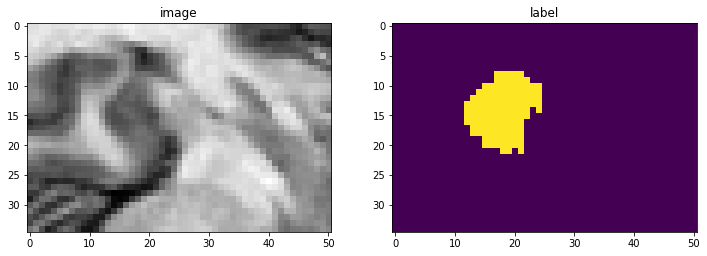

In [22]:
check_ds = Dataset(data=tf, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")

min = torch.min(image)
max = torch.max(image)
print(f"image max intensity: {max}")
print(f"image min intensity: {min}")
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 19], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 19])
plt.show()

image shape: torch.Size([40, 48, 40]), label shape: torch.Size([40, 48, 40])
image max intensity: 1.0
image min intensity: 0.0
torch.float32
<class 'torch.Tensor'>


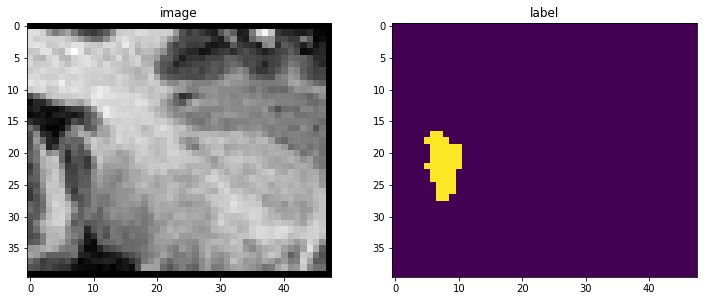

In [10]:
check_ds = Dataset(data=vf, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")

min = torch.min(image)
max = torch.max(image)
print(f"image max intensity: {max}")
print(f"image min intensity: {min}")
print(label.dtype)
print(type(label))
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 28], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 28])
plt.show()

In [11]:
def collate_fn(batch):
   batch = list(filter(lambda x: x is not None, batch))
   return torch.utils.data.dataloader.default_collate(batch)   

In [12]:
train_ds = CacheDataset(
    data=tf, transform=train_transforms, cache_rate=1.0, num_workers=0)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=False, num_workers=0)

val_ds = CacheDataset(
    data=vf, transform=val_transforms, cache_rate=1.0, num_workers=0)

val_loader = DataLoader(val_ds, batch_size=1, num_workers=0)


##normal dataloader no cache

# train_ds = Dataset(data=tf, transform=train_transforms)
# train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)

# val_ds = Dataset(data=vf, transform=val_transforms)
# val_loader = DataLoader(val_ds, batch_size=1, num_workers=0)

Loading dataset: 100%|██████████| 52/52 [00:00<00:00, 76.00it/s]


In [13]:
tstep = 0
for d in val_loader:
    i = d['image'][0][0].shape
    l = d['label'][0][0].shape

    print(f"val label dims: {d['label'][0][0].shape}")
    print(f"val image dims: {d['image'][0][0].shape}")
    ++tstep
    if tstep == 10:
      break
    if(i != l):
      print("\t im a hoe")

val label dims: torch.Size([40, 48, 40])
val image dims: torch.Size([40, 48, 40])
val label dims: torch.Size([40, 56, 40])
val image dims: torch.Size([40, 56, 40])
val label dims: torch.Size([40, 56, 48])
val image dims: torch.Size([40, 56, 48])
val label dims: torch.Size([40, 56, 32])
val image dims: torch.Size([40, 56, 32])
val label dims: torch.Size([40, 56, 32])
val image dims: torch.Size([40, 56, 32])
val label dims: torch.Size([40, 56, 32])
val image dims: torch.Size([40, 56, 32])
val label dims: torch.Size([40, 56, 40])
val image dims: torch.Size([40, 56, 40])
val label dims: torch.Size([40, 56, 40])
val image dims: torch.Size([40, 56, 40])
val label dims: torch.Size([40, 56, 40])
val image dims: torch.Size([40, 56, 40])
val label dims: torch.Size([40, 48, 40])
val image dims: torch.Size([40, 48, 40])
val label dims: torch.Size([40, 48, 40])
val image dims: torch.Size([40, 48, 40])
val label dims: torch.Size([32, 48, 48])
val image dims: torch.Size([32, 48, 48])
val label dims: 

In [14]:
tstep = 0
for d in train_loader:
    i = d['image'][0][0].shape
    l = d['label'][0][0].shape

    print(f"train label dims: {d['label'][0][0].shape}")
    print(f"train image dims: {d['image'][0][0].shape}")
    ++tstep
    if tstep == 10:
      break
    if(i != l):
      print("\t im a hoe")

train label dims: torch.Size([40, 56, 40])
train image dims: torch.Size([40, 56, 40])
train label dims: torch.Size([40, 56, 40])
train image dims: torch.Size([40, 56, 40])
train label dims: torch.Size([56, 40, 40])
train image dims: torch.Size([56, 40, 40])
train label dims: torch.Size([40, 56, 40])
train image dims: torch.Size([40, 56, 40])
train label dims: torch.Size([40, 48, 40])
train image dims: torch.Size([40, 48, 40])
train label dims: torch.Size([48, 40, 40])
train image dims: torch.Size([48, 40, 40])
train label dims: torch.Size([56, 40, 32])
train image dims: torch.Size([56, 40, 32])
train label dims: torch.Size([56, 40, 40])
train image dims: torch.Size([56, 40, 40])
train label dims: torch.Size([48, 56, 32])
train image dims: torch.Size([48, 56, 32])
train label dims: torch.Size([48, 40, 32])
train image dims: torch.Size([48, 40, 32])
train label dims: torch.Size([40, 48, 48])
train image dims: torch.Size([40, 48, 48])
train label dims: torch.Size([48, 40, 48])
train image

In [15]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,
    channels=(64, 128, 256),
    strides=(2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
    dropout=0.25
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [18]:
max_epochs = 300
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=3)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=3)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        #cur = train_ds[step-1]["image"]
        #next = train_ds[step]["image"]
        #print(f"Current img shape: {cur.shape}, next img shape: {next.shape}")
        #print(f"train inputs: {inputs.shape}")
        #print(f"train labels: {labels.shape}")
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if step % 20 == 0:
          print(
              f"{step}/{len(train_ds) // train_loader.batch_size}, "
              f"train_loss: {loss.item():.4f}")
          
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                #print(type(val_inputs))
                #print(f"val inputs: {val_inputs.shape}")
                #print(f"val labels: {val_labels.shape}")
                roi_size = (40, 48, 40)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/300
20/208, train_loss: 0.7523
40/208, train_loss: 0.7482
60/208, train_loss: 0.7462
80/208, train_loss: 0.7612
100/208, train_loss: 0.7254
120/208, train_loss: 0.7347
140/208, train_loss: 0.7082
160/208, train_loss: 0.6877
180/208, train_loss: 0.6977
200/208, train_loss: 0.6712
epoch 1 average loss: 0.7257
----------
epoch 2/300
20/208, train_loss: 0.6461
40/208, train_loss: 0.6416
60/208, train_loss: 0.6348
80/208, train_loss: 0.6538
100/208, train_loss: 0.5913
120/208, train_loss: 0.6098
140/208, train_loss: 0.5662
160/208, train_loss: 0.5174
180/208, train_loss: 0.5373
200/208, train_loss: 0.4868
epoch 2 average loss: 0.5938
saved new best metric model
current epoch: 2 current mean dice: 0.4258
best mean dice: 0.4258 at epoch: 2
----------
epoch 3/300
20/208, train_loss: 0.4311
40/208, train_loss: 0.4169
60/208, train_loss: 0.4164
80/208, train_loss: 0.5442
100/208, train_loss: 0.3648
120/208, train_loss: 0.5347
140/208, train_loss: 0.3713
160/208, train_loss: 0.

KeyboardInterrupt: ignored

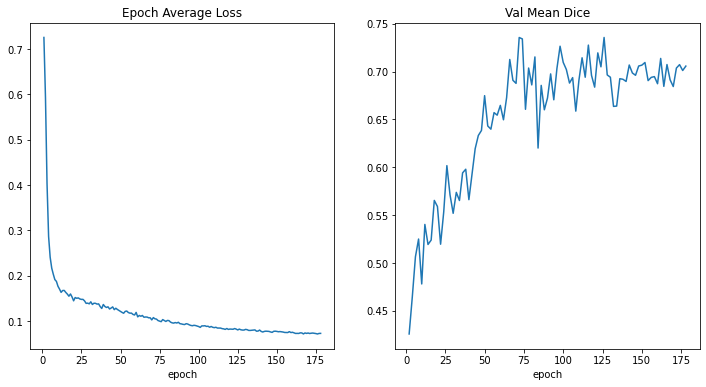

In [19]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

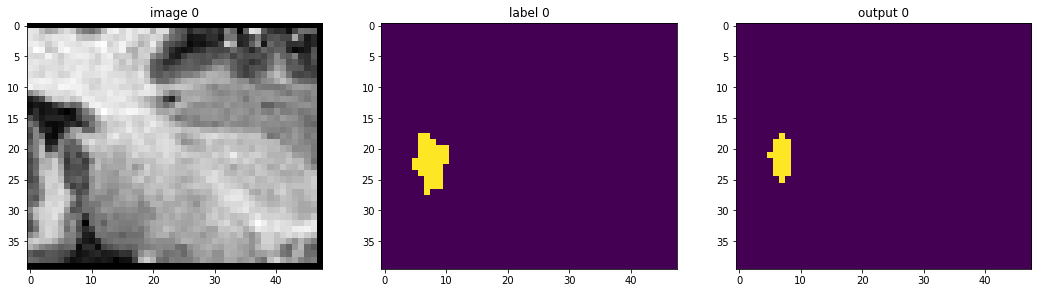

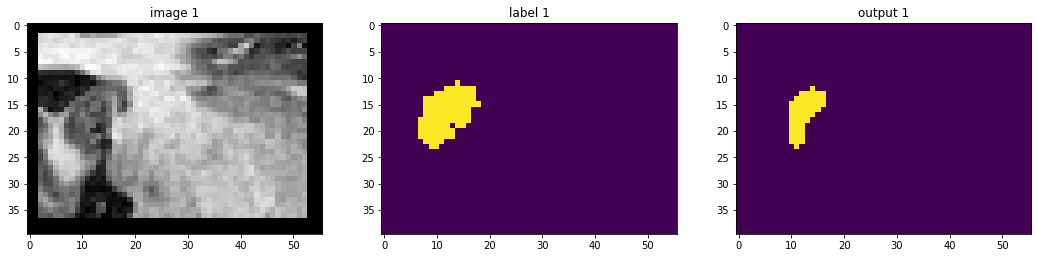

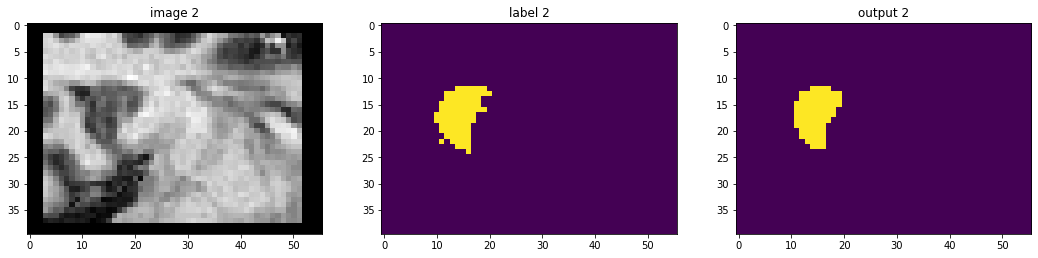

In [30]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "/content/task/best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (40, 48, 40)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 29], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 29])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 29])
        plt.show()
        if i == 2:
            break

In [28]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(
            1.0,1.0,1.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=2640,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_org_ds = Dataset(
    data=vf, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=val_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=3),
    AsDiscreted(keys="label", to_onehot=3),
])

In [29]:
model.load_state_dict(torch.load('/content/task/best_metric_model.pth'))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (40, 48, 40)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(
            val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

Metric on original image spacing:  0.7720522284507751
